In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# explore data base
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print()
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Use `engine.execute` to select and display the first 5 rows from the tables
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# Use `engine.execute` to select and display the first 5 rows from the tables
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [11]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# Calculate the date 1 year ago from the last data point in the database

# determine date of last data point
latest_date = session.query(func.max(Measurement.date)).one()
latest_date

# convert string to a date
latest_date_as_date = pd.to_datetime(latest_date)

# subtract a year
a_year_prior = latest_date_as_date - dt.timedelta(days = 365)
a_year_prior

# convert back to a string
a_year_earlier = a_year_prior.strftime('%Y-%m-%d')
a_year_earlier

Index(['2016-08-23'], dtype='object')

In [59]:
# calculate earliest date, for use in later analysis
earliest_date = session.query(func.min(Measurement.date)).one()
earliest_date

('2010-01-01')

In [16]:
# Perform a query to retrieve the date and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=a_year_earlier[0]).all()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# delete null values
precip_df = pd.DataFrame(precip).set_index('date').dropna()
# convert date string to date
precip_df.index = pd.to_datetime(precip_df.index)
# check all worked
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [18]:
precip_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2021 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prcp    2021 non-null   float64
dtypes: float64(1)
memory usage: 31.6 KB


In [19]:
# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values('date')




<function matplotlib.pyplot.show(*args, **kw)>

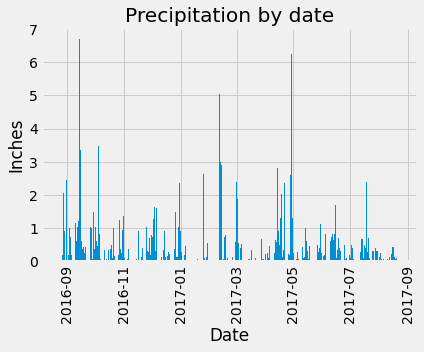

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precip_df_sorted.index, precip_df_sorted.prcp)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.title("Precipitation by date")
plt.xticks(rotation = 90)
plt.style.use('fivethirtyeight')

plt.show

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(Station.station).distinct().count()

print(f'There are {no_stations} stations.')
    

There are 9 stations.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import desc
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(desc(func.count(Measurement.station))).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(desc(func.count(Measurement.station))).limit(1).all()
most_active_station

print(f'the most active station is {most_active_station[0][0]}')

the most active station is USC00519281


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_low = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
print(f"lowest recorded temperature at {most_active_station[0][0]} is {temp_low} F")

temp_high = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
print(f"highest recorded temperature at {most_active_station[0][0]} is {temp_high} F")

temp_avg = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
print(f"average recorded temperature at {most_active_station[0][0]} is {round(temp_avg, 1)} F")

lowest recorded temperature at USC00519281 is 54.0 F
highest recorded temperature at USC00519281 is 85.0 F
average recorded temperature at USC00519281 is 71.7 F


In [50]:
# Choose the station with the highest number of temperature observations.

station_max_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
        order_by(desc(func.count(Measurement.tobs))).limit(1).all()
station_max_temp_obs

print(f'station with the highest number of temperature observations is {station_max_temp_obs[0][0]}')


station with the highest number of temperature observations is USC00519281


[('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0)]


<function matplotlib.pyplot.show(*args, **kw)>

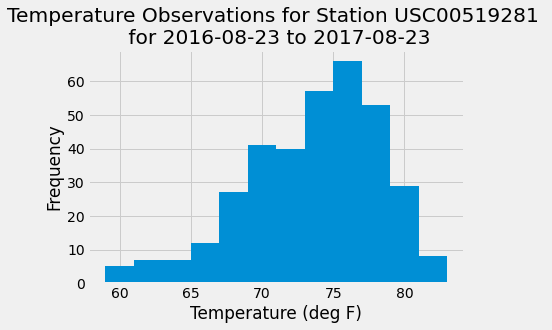

In [27]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date>=a_year_earlier[0]).all()
print(temp_data[1:5])

# This shows that temperature is the [1] element for each entry in the tuple temp_data
# extract all the temperatures as a list
temps = [obs[1] for obs in temp_data]

plt.hist(temps, bins = 12)
plt.xlabel("Temperature (deg F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {station_max_temp_obs[0][0]} \n for 2016-08-23 to 2017-08-23")
plt.show


## Bonus Challenge Assignment

Temperature Analysis I


Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?


You may either use SQLAlchemy or pandas's read_csv() to perform this portion.


Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.


Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [28]:
# find names of stations so that you can extract the data for the Honolulu station (note: misread question and did task for Honolulu station)
station_names = session.query(Station.name).distinct().all()
station_names

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [29]:
# write SELECT statement to extract date & temp for Honolulu station
stmt = "SELECT measurement.date, measurement.tobs FROM measurement \
    INNER JOIN station ON measurement.station = station.station \
        WHERE station.name = 'HONOLULU OBSERVATORY 702.2, HI US'"

# extract temperature data
with engine.connect() as con:
    rs = con.execute(stmt)
    honolulu_temps = pd.DataFrame(rs.fetchall())
    honolulu_temps.columns = rs.keys()

honolulu_temps.info()    



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1979 non-null   object 
 1   tobs    1979 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.0+ KB


In [30]:
# convert date column to datetime format
honolulu_temps['date'] = pd.to_datetime(honolulu_temps['date'])

In [31]:
# select june temps
honolulu_june_temps = honolulu_temps.loc[honolulu_temps['date'].dt.month == 6]
# get avg
avg_honolulu_june_temp = round(honolulu_june_temps['tobs'].mean(),1)
avg_honolulu_june_temp

74.1

In [32]:
# repeat for december
honolulu_dec_temps = honolulu_temps.loc[honolulu_temps['date'].dt.month == 12]
# get avg
avg_honolulu_dec_temp = round(honolulu_dec_temps['tobs'].mean(),1)
avg_honolulu_dec_temp

69.7

In [33]:
# t-test for independent means
import scipy.stats as stats
stats.ttest_ind(honolulu_june_temps['tobs'], honolulu_dec_temps['tobs'], equal_var=False)

# p < 0.05 so reject the null hypothesis that both groups are statistically the same.
# i.e December temperature is statistically different from June temperature


Ttest_indResult(statistic=9.22114727387173, pvalue=4.98987913234082e-18)

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


[[5.444444444444443], [5.555555555555557]]

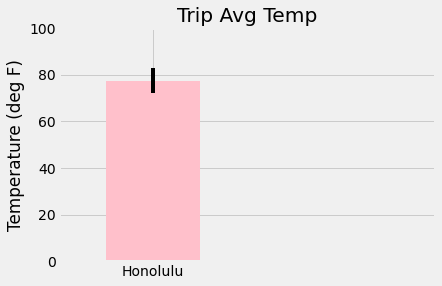

In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# choose holiday dates 2017-06-01 to 2017-06-14
holiday_temps = calc_temps('2017-06-01', '2017-06-14')
tmin = holiday_temps[0][0]
tavg = holiday_temps[0][1]
tmax = holiday_temps[0][2]

fig,ax = plt.subplots()

yerr = [[tavg-tmin], [tmax - tavg]]

ax.bar('Honolulu',tavg, width = 1, color = 'pink', yerr = yerr)
ax.set_ylabel('Temperature (deg F)')

ax.set_title('Trip Avg Temp')
ax.set_xlim(-1,3)
ax.set_ylim(0, 100)


plt.show

yerr


In [57]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-06-01'
end_date = '2017-06-14'

total_rain = session.query(func.sum(Measurement.prcp),\
     Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
   

total_rain_df = pd.DataFrame(total_rain, columns = ['total_prcp', 'station', 'name', 'latitude', 'longitude', 'elevation'])
total_rain_df

,total_prcp,station,name,latitude,longitude,elevation
0,3.82,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,2.43,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,1.79,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,1.72,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.76,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.16,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,NaN,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [102]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-06-01'
end_date = '2017-06-14'

# Use the start and end date to create a range of dates
dates = pd.date_range(start_date, end_date)
dates_2 = pd.to_datetime(dates)

# Stip off the year and save a list of %m-%d strings
dates_3 = dates_2.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
# note np.ravel flattens an array 
holiday_normals = []
for date in dates_3:
    holiday_normals.append(list(np.ravel(daily_normals(date))))


In [103]:
holiday_normals

[[64.0, 74.6140350877193, 81.0],
 [65.0, 74.4, 81.0],
 [65.0, 74.03448275862068, 80.0],
 [65.0, 73.81818181818181, 81.0],
 [68.0, 74.85454545454546, 81.0],
 [70.0, 75.17543859649123, 80.0],
 [68.0, 75.07142857142857, 81.0],
 [70.0, 75.58620689655173, 81.0],
 [69.0, 75.15254237288136, 81.0],
 [68.0, 75.14285714285714, 81.0],
 [69.0, 76.01960784313725, 84.0],
 [66.0, 75.66666666666667, 83.0],
 [68.0, 75.66666666666667, 81.0],
 [69.0, 75.62711864406779, 81.0]]

In [108]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
holiday_normals_pd = pd.DataFrame(holiday_normals, index = dates_2, columns = ['tmin', 'tavg', 'tmax'])
holiday_normals_pd


,tmin,tavg,tmax
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0


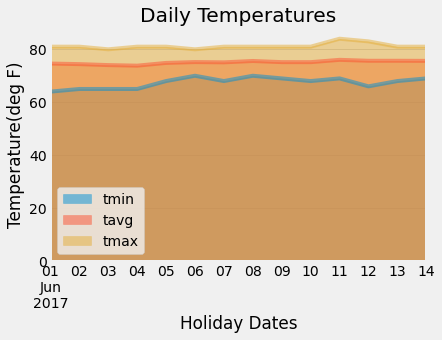

In [114]:
# Plot the daily normals as an area plot with `stacked=False`
holiday_normals_pd.plot.area(stacked = False)
plt.ylabel('Temperature(deg F)')
plt.xlabel('Holiday Dates')
plt.title('Daily Temperatures')
plt.tight_layout
plt.show()


In [41]:
session.close()